In [1]:
import pandas as pd
from datasets import Dataset
df = pd.read_csv("/kaggle/input/golang-8/filtered_data.tsv", sep="\t")
dataset = Dataset.from_pandas(df)
print(len(dataset))

441187


In [2]:
def preprocess_function(examples):
    return {
        "Incorrect": str(examples["Incorrect"]),
        "Corrected": str(examples["Corrected"])
    }
small_dataset = dataset.train_test_split(train_size=0.3)["train"]
dataset = small_dataset.map(preprocess_function)

Map:   0%|          | 0/132356 [00:00<?, ? examples/s]

In [3]:
split = dataset.train_test_split(test_size=0.2)
train_data = split["train"]
valid_data = split["test"]
print(len(train_data))
print(len(valid_data))

105884
26472


In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-base")

def tokenize_function(examples):
    prefix = "grammar correction: "

    incorrect_texts = [prefix + str(text) for text in examples["Incorrect"]]
    correct_texts = [str(text) for text in examples["Corrected"]]

    inputs = tokenizer(
        incorrect_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
    )
    targets = tokenizer(
        correct_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt"
    )

    inputs["labels"] = targets["input_ids"]
    return inputs

train_data = train_data.map(tokenize_function, batched=True)
valid_data = valid_data.map(tokenize_function, batched=True)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/105884 [00:00<?, ? examples/s]

Map:   0%|          | 0/26472 [00:00<?, ? examples/s]

In [5]:
from transformers import Trainer, Seq2SeqTrainingArguments, AutoModelForSeq2SeqLM

# Load pre-trained T5 model
model = AutoModelForSeq2SeqLM.from_pretrained("t5-base")

training_args = Seq2SeqTrainingArguments(
    output_dir="./t5_grammar_correction",
    eval_strategy="epoch",  # Evaluate after each epoch
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    lr_scheduler_type="linear", # Linearly decreases it to zero over the course of training
    warmup_steps=500, # Gradually increase learning rate for first 500 steps
    
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps = 2,  # Effective batch size becomes 8 * 2 = 16
    
    learning_rate=5e-4,
    weight_decay=0.01,
    
    predict_with_generate=True,
    metric_for_best_model="eval_f0_5",
    report_to="none",
    load_best_model_at_end=True,
)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [6]:
from peft import get_peft_model, LoraConfig, TaskType

# Define LoRA Configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    inference_mode=False,
    r=8,                # Rank of LoRA
    lora_alpha=32,
    lora_dropout=0.1
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 884,736 || all params: 223,788,288 || trainable%: 0.3953


In [7]:
!pip install jiwer
import torch
from nltk.tokenize import word_tokenize
from nltk.translate.gleu_score import sentence_gleu
from nltk.tokenize import word_tokenize
from transformers import EvalPrediction
import numpy as np
from jiwer import cer

def postprocess_labels(labels, tokenizer):
    return [
        [token if token != -100 else tokenizer.pad_token_id for token in label_seq]
        for label_seq in labels
    ]
    
def compute_metrics(eval_pred):
    preds = eval_pred.predictions
    labels = eval_pred.label_ids
    preds, labels = eval_pred

    # Convert logits to predicted token ids
    clean_preds = postprocess_labels(preds, tokenizer)
    pred_texts = tokenizer.batch_decode(clean_preds, skip_special_tokens=True)
    clean_labels = postprocess_labels(labels, tokenizer)
    label_texts = tokenizer.batch_decode(clean_labels, skip_special_tokens=True)

    tokenized_preds = [word_tokenize(p) for p in pred_texts]
    tokenized_labels = [word_tokenize(l) for l in label_texts]

    # Compute sentence-level GLEU
    gleu_scores = []
    for pred, ref in zip(tokenized_preds, tokenized_labels):
        if len(pred) >= 1 and len(ref) >= 1:
            try:
                score = sentence_gleu([ref], pred)  # ref must be wrapped in a list
                gleu_scores.append(score)
            except Exception:
                gleu_scores.append(0.0)
        else:
            gleu_scores.append(0.0)

    avg_sentence_gleu = np.mean(gleu_scores)

    # Character Error Rate
    filtered_pairs = [(ref, hyp) for ref, hyp in zip(label_texts, pred_texts) if ref.strip()]
    cer_scores = [cer(ref, hyp) for ref, hyp in filtered_pairs]
    cer_value = np.mean(cer_scores)
    
    # Precision, Recall, F0.5
    TP = 0  # Correct tokens
    FP = 0  # Extra tokens in pred
    FN = 0  # Missing tokens in pred

    for pred, label in zip(tokenized_preds, tokenized_labels):
        min_len = min(len(pred), len(label))
        for i in range(min_len):
            if pred[i] == label[i]:
                TP += 1
            else:
                FP += 1
                FN += 1
        FP += max(0, len(pred) - len(label))  # Remaining pred tokens are FP
        FN += max(0, len(label) - len(pred))  # Remaining label tokens are FN

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    beta_squared = 0.5 ** 2
    f0_5 = (1 + beta_squared) * precision * recall / (beta_squared * precision + recall) if (precision + recall) > 0 else 0.0

    return {
        "gleu": avg_sentence_gleu,
        "cer": cer_value,
        "precision": precision,
        "recall": recall,
        "f0_5": f0_5
    }


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 58.1 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7


In [8]:
from transformers import Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=valid_data,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)


In [9]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss,Gleu,Cer,Precision,Recall,F0 5
1,0.092400,0.085310,0.577481,0.232851,0.571445,0.482896,0.551230
2,0.084500,0.082369,0.582687,0.230383,0.576374,0.487449,0.556085
3,0.092400,0.080800,0.585811,0.228915,0.578177,0.488763,0.557770
4,0.077700,0.080068,0.586279,0.228649,0.578633,0.488645,0.558078
5,0.083700,0.079755,0.588217,0.227687,0.580908,0.490778,0.560328
6,0.076100,0.079079,0.589224,0.227795,0.581592,0.491759,0.561092
7,0.079500,0.079037,0.589973,0.227484,0.582515,0.492776,0.562044
8,0.078600,0.078756,0.590918,0.227512,0.582576,0.492806,0.562097
9,0.079100,0.078538,0.590839,0.227799,0.583155,0.493580,0.562730


TrainOutput(global_step=16540, training_loss=0.15522139279989405, metrics={'train_runtime': 31994.2048, 'train_samples_per_second': 33.095, 'train_steps_per_second': 0.517, 'total_flos': 1.6182433785367757e+17, 'train_loss': 0.15522139279989405, 'epoch': 9.994258084013296})

In [10]:
# Save model and tokenizer
model.save_pretrained("./t5_grammar_corrector")
tokenizer.save_pretrained("./t5_grammar_corrector")

('./t5_grammar_corrector/tokenizer_config.json',
 './t5_grammar_corrector/special_tokens_map.json',
 './t5_grammar_corrector/spiece.model',
 './t5_grammar_corrector/added_tokens.json',
 './t5_grammar_corrector/tokenizer.json')

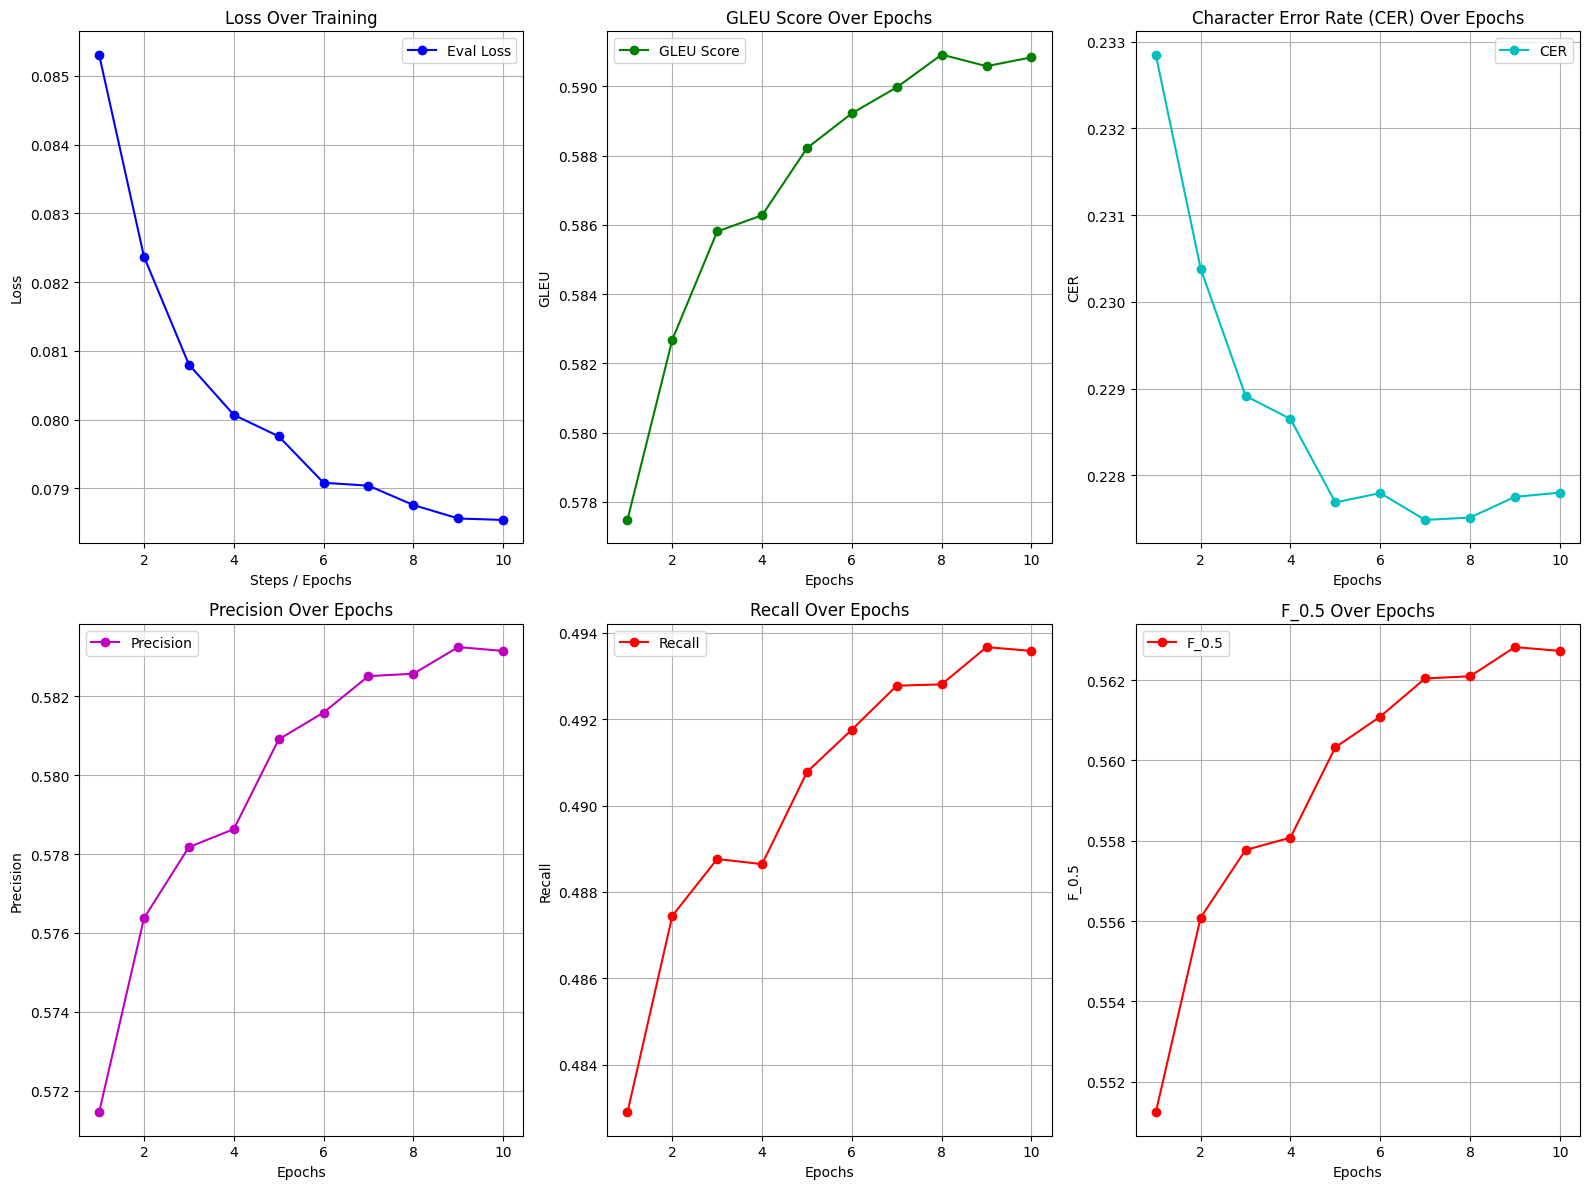

In [11]:
import matplotlib.pyplot as plt

# Extract logged history (simulated for demonstration purposes)
log_history = trainer.state.log_history

# Extract different metrics
train_losses = [entry["loss"] for entry in log_history if "loss" in entry]
eval_losses = [entry["eval_loss"] for entry in log_history if "eval_loss" in entry]
gleu_scores = [entry["eval_gleu"] for entry in log_history if "eval_gleu" in entry]
cer_scores = [entry["eval_cer"] for entry in log_history if "eval_cer" in entry]
precision = [entry["eval_precision"] for entry in log_history if "eval_precision" in entry]
recall = [entry["eval_recall"] for entry in log_history if "eval_recall" in entry]
f0_5 = [entry["eval_f0_5"] for entry in log_history if "eval_f0_5" in entry]
# Create epochs range based on the number of metrics
epochs = list(range(1, len(eval_losses) + 1))

# Plotting all metrics
plt.figure(figsize=(16, 12))

# Subplot 1: Evaluation & Training Loss
plt.subplot(2, 3, 1)
plt.plot(epochs, eval_losses, marker='o', linestyle='-', color='b', label="Eval Loss")
plt.xlabel("Steps / Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Training")
plt.legend()
plt.grid(True)

# Subplot 2: GLEU Score
if gleu_scores:
    plt.subplot(2, 3, 2)
    plt.plot(epochs, gleu_scores, marker='o', linestyle='-', color='g', label="GLEU Score")
    plt.xlabel("Epochs")
    plt.ylabel("GLEU")
    plt.title("GLEU Score Over Epochs")
    plt.legend()
    plt.grid(True)


# Subplot 2: Character Error Rate (CER)
if cer_scores:
    plt.subplot(2, 3, 3)
    plt.plot(epochs, cer_scores, marker='o', linestyle='-', color='c', label="CER")
    plt.xlabel("Epochs")
    plt.ylabel("CER")
    plt.title("Character Error Rate (CER) Over Epochs")
    plt.legend()
    plt.grid(True)

# Subplot 3: Precision
if precision:
    plt.subplot(2, 3, 4)
    plt.plot(epochs, precision, marker='o', linestyle='-', color='m', label="Precision")
    plt.xlabel("Epochs")
    plt.ylabel("Precision")
    plt.title("Precision Over Epochs")
    plt.legend()
    plt.grid(True)

# Subplot 4: Recall
if recall:
    plt.subplot(2, 3, 5)
    plt.plot(epochs, recall, marker='o', linestyle='-', color='r', label="Recall")
    plt.xlabel("Epochs")
    plt.ylabel("Recall")
    plt.title("Recall Over Epochs")
    plt.legend()
    plt.grid(True)

# Subplot 5: F0.5
if f0_5:
    plt.subplot(2, 3, 6)
    plt.plot(epochs, f0_5, marker='o', linestyle='-', color='r', label="F_0.5")
    plt.xlabel("Epochs")
    plt.ylabel("F_0.5")
    plt.title("F_0.5 Over Epochs")
    plt.legend()
    plt.grid(True)
    
# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [12]:
import torch
from peft import PeftModel

def correct_sentence(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: value.to(device) for key, value in inputs.items()}
    outputs = model.generate(**inputs, max_length=128, num_beams=5)
    
    corrected_sentence = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return corrected_sentence
    
# Load the model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("./t5_grammar_corrector")
model = PeftModel.from_pretrained(model, "./t5_grammar_corrector")
tokenizer = AutoTokenizer.from_pretrained("./t5_grammar_corrector")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
    
test_sentences = [
    "He go to school.",
    "She like play soccer.",
    "I has a apple.",
    "We goes to the market every day.",
    "Tomorow we will going shop",
    "She don’t likes going to the store because it make her feel bad every time she go.",
    "He walk to school every day even when it are raining",
    "Me and my cousin was going to the mall yesterday but we seen that it were closed so we decides to goes to the park instead where there was lots of childrens playing and peoples walking they dogs, and then we eaten some ice cream which it didn’t taste very good because they melted too fast and the cones was broke but we still was happy because we don’t got nothing better to do on them kind of days."
]

for sentence in test_sentences:
    corrected = correct_sentence(sentence)
    print(f"Incorrect: {sentence}")
    print(f"Corrected: {corrected}\n")

Incorrect: He go to school.
Corrected: He goes to school .

Incorrect: She like play soccer.
Corrected: She likes to play soccer .

Incorrect: I has a apple.
Corrected: I have an apple .

Incorrect: We goes to the market every day.
Corrected: We go to the market every day .

Incorrect: Tomorow we will going shop
Corrected: Tomorow we will go shopping .

Incorrect: She don’t likes going to the store because it make her feel bad every time she go.
Corrected: She doesn’t like going to the store because it makes her feel bad every time she goes .

Incorrect: He walk to school every day even when it are raining
Corrected: He walks to school every day even when it is raining .

Incorrect: Me and my cousin was going to the mall yesterday but we seen that it were closed so we decides to goes to the park instead where there was lots of childrens playing and peoples walking they dogs, and then we eaten some ice cream which it didn’t taste very good because they melted too fast and the cones was 